# Sex Descrimination in Employment - An Observational Study
There are 32 male and 61 femail employees, hired between 1965 and 1975, who were considered for a study.  The measurements are of annual salary at time of hire, salary as of March 1977, sex, seniority (months since first hired), age (months), education (years), and work experience prior to employment with the bank (months).

Did the females receive lower starting salaries than similarly qualified and similarly experienced males?  After accounting for measures of performance, did females receive smaller pay increases of males?

In [1]:
# 3rd party library imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

sns.set()
pd.options.display.float_format = "{:.3f}".format
pd.options.display.max_columns = 12

In [2]:
df = pd.read_csv('case1202.csv')
df.head()

,Bsal,Sal77,Sex,Senior,Age,Educ,Exper
0,5040,12420,Male,96,329,15,14.000
1,6300,12060,Male,82,357,15,72.000
2,6000,15120,Male,67,315,15,35.500
3,6000,16320,Male,97,354,12,24.000
4,6000,12300,Male,66,351,12,56.000


In [3]:
df.describe()

,Bsal,Sal77,Senior,Age,Educ,Exper
count,93.000,93.000,93.000,93.000,93.000,93.000
mean,5420.323,10392.903,82.280,474.398,12.505,100.927
std,709.587,1789.641,10.255,140.210,2.282,90.947
min,3900.000,7860.000,65.000,280.000,8.000,0.000
25%,4980.000,9000.000,74.000,349.000,12.000,35.500
50%,5400.000,10020.000,84.000,468.000,12.000,70.000
75%,6000.000,11220.000,90.000,590.000,15.000,144.000
max,8100.000,16320.000,98.000,774.000,16.000,381.000


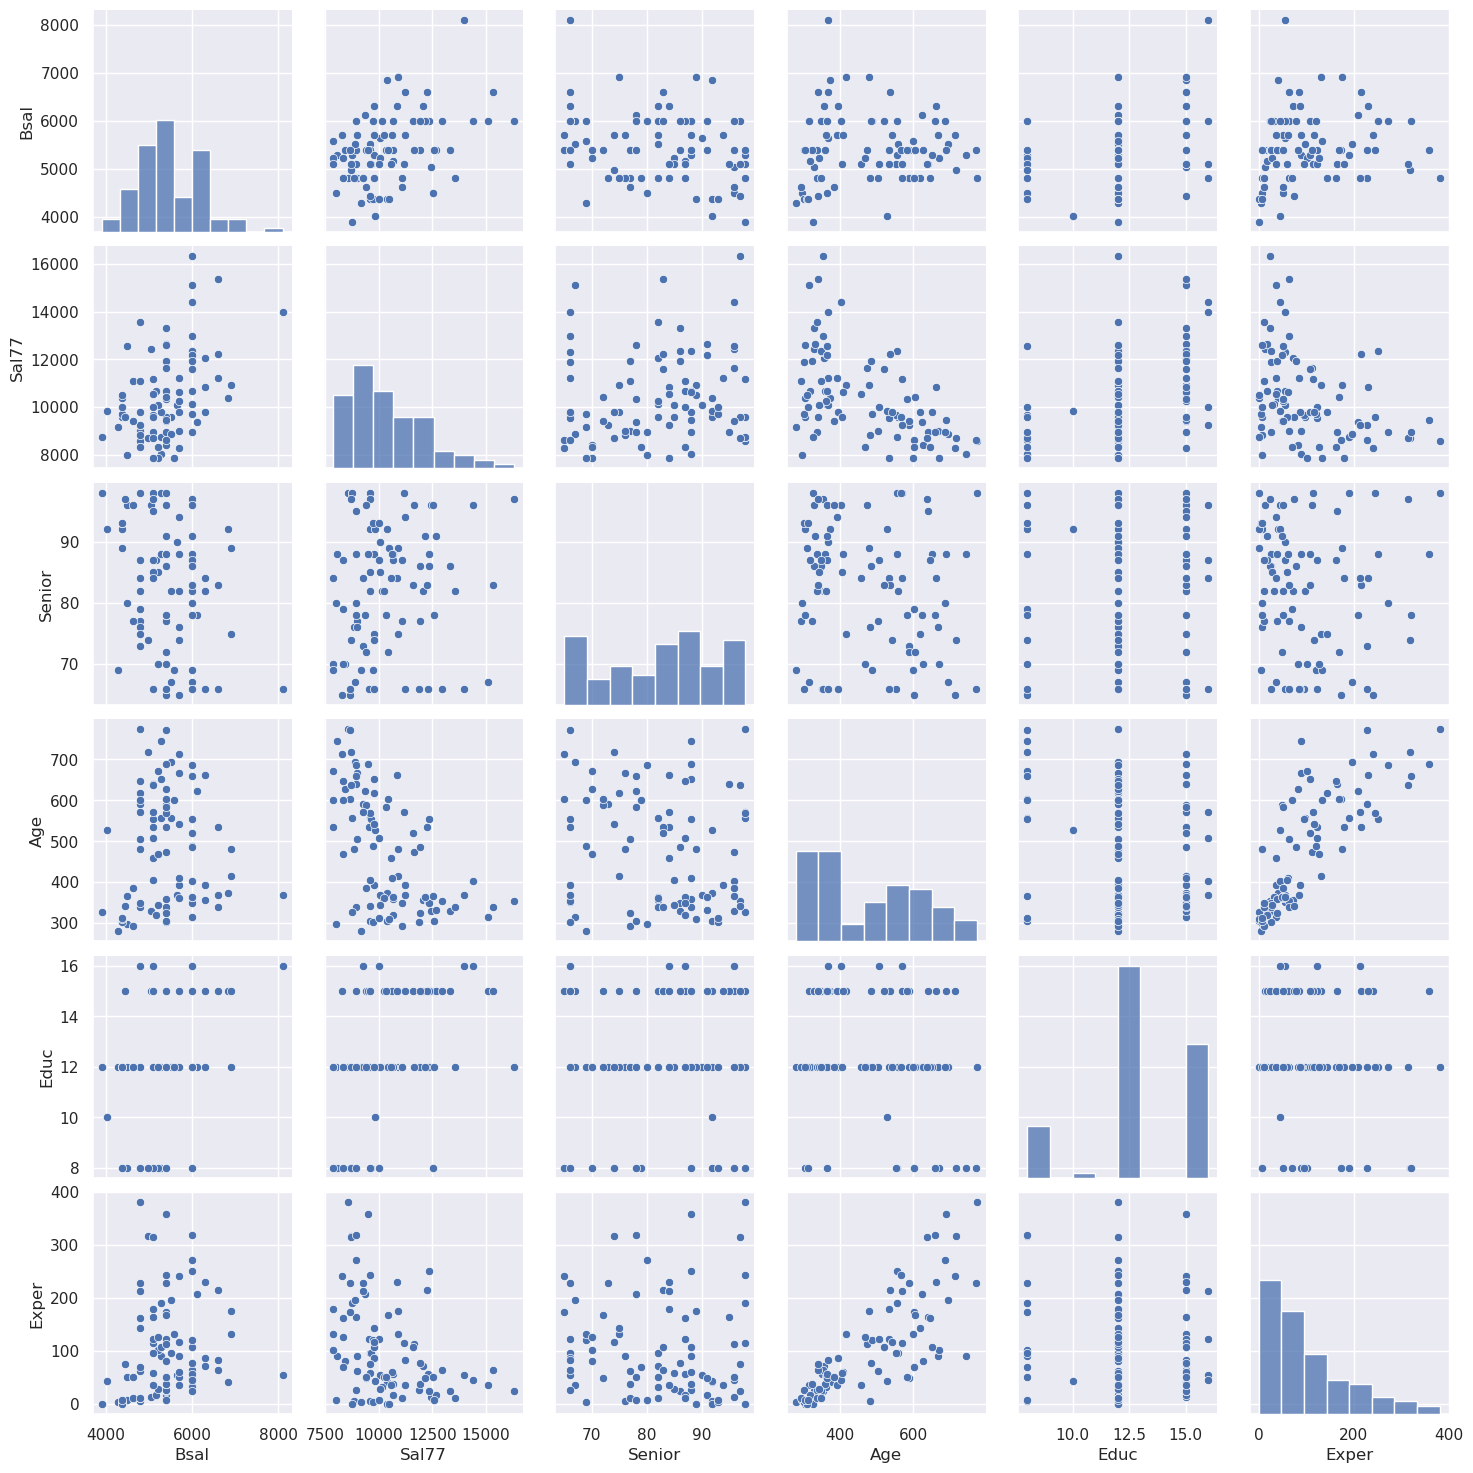

In [4]:
sns.pairplot(df)

*Bsal* suggests a possible non-linear relationship.  Perhaps a log-transformation is in order here, so the endogenous term will be `np.log(Bsal)`.  The interesting/tedious part will be to construct all the formulae out of all the combinations.

In [5]:
endogenous = "np.log(Bsal)"

# Single terms
single = [x for x in df.columns[1:] if x not in ['Sal77', 'Sex']]

# Create all the formulae out of the single terms
import itertools
formulae = []
for i in range(1, len(single) + 1):
    for iterms in itertools.combinations(single, i):
        exogeneous = ' + '.join(iterms)
        formulae.append(exogeneous)                                                


In [6]:
# It's not good to include a quadratic term unless the corresponding first order term is
# also present.                                                                    
quadformulae = []                                                                  
for formula in formulae:                                                           
    terms = [x for x in formula.split(' + ')]                                                
    for i in range(1, len(terms) + 1):                                             
        for iterms in itertools.combinations(terms, i):                            
            exogeneous_extra = ' + '.join([f'np.power({item}, 2)' for item in iterms])
            exogeneous = f"{formula} + {exogeneous_extra}"                         
            quadformulae.append(exogeneous)                                        
                                                                                   
formulae = formulae + quadformulae  

In [7]:
# Ditto for the mixed terms.                                                       
mixedformulae = []                                                                 
for formula in formulae:                                                           
    terms = [term for term in formula.split(' + ') if 'np.pow' not in term]        
    if len(terms) < 2:                                                             
        continue                                                                   
    for i in range(2, len(terms) + 1):                                             
        for iterms in itertools.combinations(terms, i):                            
            exogeneous_extra = ' + '.join([f'{item[0]}:{item[1]}' for item in itertools.combinations(iterms, 2)])
            exogeneous = f"{formula} + {exogeneous_extra}"                         
            mixedformulae.append(exogeneous)                                       
                                                                                   
formulae = formulae + mixedformulae                                                
print(len(formulae))

formulae = [f"np.log(Bsal) ~ Sex + {formula}" for formula in formulae]

408


In [8]:
aics = []
bics = []
fvalues = []
cps = []
for formula in formulae:
    model_fit = smf.ols(formula=formula, data=df).fit()
    aics.append(model_fit.aic)
    bics.append(model_fit.bic)
    fvalues.append(model_fit.fvalue)
    
    sse = model_fit.mse_model * model_fit.df_model
    dof = model_fit.nobs - 1
    sst = model_fit.mse_total * dof
    p = len(model.exog_names) - 1
    cp = sse / sst ** 2 - model_fit.nobs + 2 * p
    cps.append(cp)

kwargs = {
    'formula': formulae, 
    'aic': aics, 
    'bic': bics, 
    'fvalue': fvalues,
    'cp': cps
}
dfcp = pd.DataFrame(kwargs)

dfcp.sort_values(by='bic').head()

NameError: name 'model' is not defined

Now run statsmodels on all the formulae!

# Statistical Conclusion
The data provide convincing evidence that the median starting salary for females was lower than the median starting salary for males, even after the effects of age, education, previous experience, and time at which the job began are taken into account (one-sided $p$-value < 0.0001).  The median starting salary for females was estimated to be only 89% of the median salary for males, after accounting for the variables measured above (a 95% confidence interval for the ratio of adjusted medians is 85% to 93%).   There is little evidence that the pay increases for females differed from those for males (one-sided $p$-value  0.27 from a $t$-test for the difference in mean log of average annual raise; one-sided $p$-value = 0.72 after further adjustment for other variables except beginning salary; one-sided $p$-value = 0.033 after further adjustment for other variables including beginning salary).